In [38]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import cv2
from functools import reduce
import random
import math
import matplotlib.pyplot as plt

In [43]:
theta = np.linspace(0, 8*np.pi, 250000)  # 각도 범위를 정의합니다.
radius = np.linspace(0, 6, 250000)  # 반지름 범위를 정의합니다.
xx = radius * np.cos(theta) + 0.05 * np.random.randn(250000)  # x 좌표 계산
yy = radius * np.sin(theta) + 0.05 * np.random.randn(250000)  # y 좌표 계산

x = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성
print("x shape = ", x.shape)

x shape =  (250000, 2)


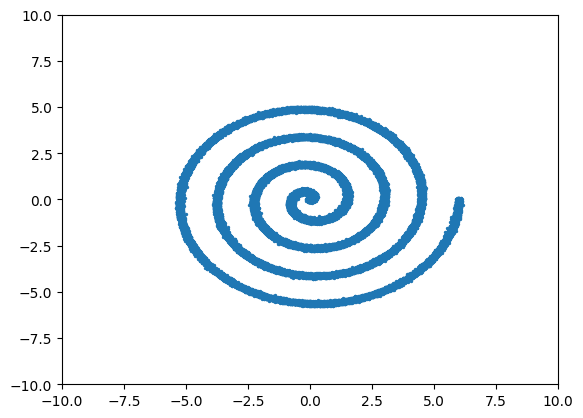

In [44]:
np.random.shuffle(x)
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.show()

In [63]:
noise_qubits = 2
code_qubits = 1
n_qubits = noise_qubits + code_qubits
n_layers = 3
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("ionq.simulator", wires=2)
# dev = qml.device("ionq.qpu", wires=2)

n_qubits = 3 n_layers = 3


In [64]:
generator_params = Variable(torch.tensor(np.random.normal(0, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
generator_opt = torch.optim.Adam([generator_params], lr=0.005)
print("parameter shape: ", generator_params.shape)

parameter shape:  torch.Size([3, 3, 3])


In [69]:
def generator_init(generator_input):
    
    for i in range(n_qubits):
        qml.RY(generator_input[i][0]*np.pi, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RY(params[i][0], wires=i)
        qml.RX(params[i][1], wires=i)
        qml.RY(params[i][2], wires=i)
    
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            qml.CNOT(wires=[i, j])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit node
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    마지막 측정은 모두 Z로
    """

    generator_init(generator_input)

    for param in params:
        layer(param)

    Z = reduce(lambda x, y: x @ y, [qml.PauliZ(i) for i in range(n_qubits)])
    return qml.expval(Z)


def generator_cost_fn(params):

    generator_input = torch.randu((BATCH_SIZE, n_qubits))

    generator_output = circuit(params, generator_input)
    generator_output = generator_output[:noise_qubits] # 출력 큐비트만 얻는다
    
    gan_loss = torch.log(1-Dx_tilde).mean()

    output = circuit(params, generator_input)
    cost = 0
    cost += torch.square(-circuit(params, pos_input)+1)
    cost += torch.square(circuit(params, neg_input)+1)
    #cost -= torch.log(circuit(params, pos_input)+1)
    #cost -= torch.log(-circuit(params, neg_input)+1)
    return cost


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [72]:
    generator_input = torch.rand((BATCH_SIZE, n_qubits))

    generator_output = circuit(generator_params, generator_input)
    generator_output.shape

ValueError: too many values to unpack (expected 2)

In [71]:
# input is 4*4 image
def init(input):
    image, number = input

    for i in range(data_qubits):
        qml.RY(image[i][0] * np.pi/2, wires=i)
        qml.RZ(image[i][1] * np.pi/2, wires=i)
        qml.RX(image[i][2] * np.pi/2, wires=i)
        qml.RY(image[i][3] * np.pi/2, wires=i)

    qml.Hadamard(wires=n_qubits-1)
    qml.RZ(number * np.pi/2, wires=n_qubits-1)
    for i in range(data_qubits):
        qml.CNOT(wires=[i, n_qubits-1])

def layer(params):
    for i in range(n_qubits):
        qml.RY(params[i][0], wires=i)
        qml.MultiRZ(params[i][1], wires=[j for j in range(i+1)])
        qml.RX(params[i][2], wires=i)
        qml.RY(params[i][3], wires=i)
    
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            qml.CNOT(wires=[i, j])


# Kraus matrix for layer probability normalization
K0 = np.array([[math.sqrt(0.5), 0], [0, 0]])
K1 = np.array([[0, 0], [0, math.sqrt(0.5) * 1j]])
K2 = np.array([[0, math.sqrt(0.5)], [math.sqrt(0.5), 0]])

def normalization():
    for i in range(n_qubits):
        qml.QubitChannel([K0, K1, K2], wires=i)


@qml.qnode(dev, interface="torch")
def circuit(params, input):
    """
    quantum circuit node
    params (np.array): a parameter
    input (np.array, boolean): (input data, positive type) tuple
    """
    init(input)

    for i in range(len(params)):
        layer(params[i])
        if i < len(params) - 1:
            normalization()

    Z = reduce(lambda x, y: x @ y, [qml.PauliZ(i) for i in range(n_qubits)])
    return qml.expval(Z)


def cost_fn(params, pos_input, neg_input):
    cost = 0
    cost += torch.square(-circuit(params, pos_input)+1)
    cost += torch.square(circuit(params, neg_input)+1)
    #cost -= torch.log(circuit(params, pos_input)+1)
    #cost -= torch.log(-circuit(params, neg_input)+1)
    return cost


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [16]:
import matplotlib.pyplot as plt  # matplotlib 라이브러리를 불러온다.


def layer_visualization(params, test_inds, epoch=0):
    datas = [[(x_test_reshape[test_inds[i]], y_test[test_inds[i]]),
            (x_test_reshape[test_inds[i]], 1-y_test[test_inds[i]])] for i in range(6)]
        
    fig, axs = plt.subplots(2, 3, figsize=(14, 9))  # 2*2 그래프를 만든다.
    positions = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]

    for j in range(6):
        pos_result = []
        neg_result = []
        (x, y) = positions[j]
        for i in range(n_layers):
            pos_result.append(float(circuit(params[:i+1], datas[j][0])))
            neg_result.append(float(circuit(params[:i+1], datas[j][1])))
        
        axs[x, y].set_title(f"red(+) is {datas[j][0][1]} ind={test_inds[j]}")
        axs[x, y].plot(list(range(1, n_layers+1)), pos_result, '--ro')
        axs[x, y].plot(list(range(1, n_layers+1)), neg_result, '--bo')
        axs[x, y].axhline(y=0, color='g')

    if epoch > 0:
        plt.savefig(f'graphs/epoch{epoch}.png')
        plt.close(fig)
    else:
        plt.show()


In [17]:
import random

n_epochs = 100
best_params = []
best_cost = 1e10
train_size = 50+50
val_size = 30

inputs = []
answers = []
while True:
    train_inds = random.sample(
        list(range(0, len(x_train_reshape))), train_size)
    inputs = x_train_reshape[train_inds]
    answers = y_train[train_inds]
    if sum(answers) * 2 == len(answers):
        break

print(float(sum(answers))/len(answers))
print(x_test_reshape.shape, y_test.shape)

for epoch in range(n_epochs):

    loss_sum = 0
    data = list(zip(inputs, answers))
    random.shuffle(data)
    inputs, answers = zip(*data)

    for ind in range(len(inputs)):
        x = inputs[ind]
        y = answers[ind]
        # reverse training
        for i in range(n_layers-1, -1, -1):
            loss = cost_fn(qnn_params[:i+1], (x, y), (x, 1-y))
            loss_sum += loss
            opts[i].zero_grad()
            loss.requires_grad_(True)
            loss.backward()
            opts[i].step()
        if (ind % 20 == 19):
            print("{} / {} done, loss = ".format(ind +
                  1, len(inputs)), float(loss_sum))

    if loss_sum < best_cost:
        best_cost = loss_sum
        best_params = qnn_params

    test_inds = random.sample(list(range(len(x_test_reshape))), val_size)
    zero = []
    one = []
    acc = 0
    for ind in range(val_size):
        test_input = x_test_reshape[test_inds[ind]]
        a, b, c = prediction(qnn_params, test_input, debug=True)
        acc += int(a == y_test[test_inds[ind]])
        zero.append(round(float(b), 6))
        one.append(round(float(c), 6))
    print(f"epoch = {epoch} loss = {round(float(loss_sum), 6)}",
          f"0: {sum(zero)} 1: {sum(one)} acc = {acc} / {val_size} ")
    print(zero)
    print(one)

    if True:
        layer_visualization(qnn_params, test_inds, epoch=epoch+1)


0.5
(1968, 4, 4) (1968,)
20 / 100 done, loss =  119.76547587158527
40 / 100 done, loss =  240.56320614154035
60 / 100 done, loss =  360.6338277972074
80 / 100 done, loss =  481.87929897916723
100 / 100 done, loss =  599.6917675957857
epoch = 0 loss = 599.691768 0: 2.360898 1: 3.0168700000000004 acc = 22 / 30 
[0.07778, 0.082352, 0.077508, 0.081403, 0.08149, 0.06318, 0.080905, 0.077808, 0.080184, 0.077341, 0.082055, 0.077526, 0.078057, 0.082023, 0.079978, 0.081168, 0.077645, 0.085463, 0.080122, 0.078585, 0.078414, 0.067889, 0.077526, 0.077774, 0.082504, 0.082044, 0.069767, 0.081424, 0.079299, 0.081684]
[0.274603, 0.086776, 0.277696, 0.174365, -0.014191, 0.120416, 0.074344, 0.27409, 0.037843, -0.056331, 0.020364, -0.059237, 0.277096, 0.023459, 0.219205, 0.090791, 0.276598, 0.124924, -0.001599, 0.273339, 0.0171, 0.092562, -0.059237, -0.059046, 0.031331, 0.076492, 0.120262, 0.109858, -0.00994, 0.202937]
20 / 100 done, loss =  119.02625086700992
40 / 100 done, loss =  236.70997912000806
60 

KeyboardInterrupt: 